In [1]:
import ipywidgets as widgets
from traitlets import Unicode, validate

class KeyWidget(widgets.DOMWidget):
    _view_name = Unicode('KeyView').tag(sync=True)
    _view_module = Unicode('keyview').tag(sync=True)
    current_key = Unicode('nothing').tag(sync=True)
    

In [2]:
%%javascript
require.undef('keyview');

window.inputElement = undefined;

define('keyview', ["jupyter-js-widgets"], function(widgets) {

    var KeyView = widgets.DOMWidgetView.extend({
        render: function() {
            this.el.textContent = 'Press a key to tag the image below.';
            
            document.onkeydown = function(evt) {
                if (window.inputElement === undefined || window.inputElement !== document.activeElement) { return; }
                evt = evt || window.event;
                this.model.set("current_key", "None");
                this.touch();
                this.model.set("current_key", evt.key);
                this.touch();
            }.bind(this);
        }
    });

    return {
        KeyView: KeyView
    }
});

<IPython.core.display.Javascript object>

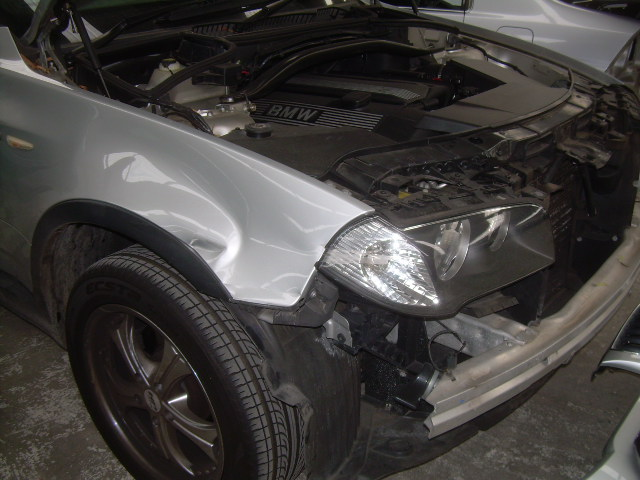

[At image 8010/68599]
[Counts: 397 part, 8518 not part]
1: part, 2: not part


In [3]:
from IPython.display import Image, display, clear_output, HTML
from tag_image_tools import Folder, Cat, all_categories, top, images, all_image_names

print("All categories: " + str(list([cat.name for cat in all_categories])))

def input_category(q):
    value = input(q)
    for cat in all_categories:
        if cat.name == value: return cat
    return None

selected_category = input_category("Enter a category: ")
while selected_category is None:
    selected_category = input_category("Please enter a valid category: ")

def image_should_show(image_name):
    if image_name in deleted_image_names: return True
    if selected_category.no.has(image_name) or selected_category.yes.has(image_name): return False
    for cat in all_categories:
        if cat.name == selected_category.name: continue
        if cat.yes.has(image_name): return False
    return True

def image_set(image_name, value):
    if value:
        selected_category.no.remove(image_name)
        images.copy(image_name, selected_category.yes)
    else:
        selected_category.yes.remove(image_name)
        images.copy(image_name, selected_category.no)
        
num_yes = selected_category.num_yes
num_no = selected_category.num_no
num = len(all_image_names)

tag_map = {
    "1": True,
    "2": False
}

class TagInput:
    def __init__(self, key):
        self.key = key
        self.tag = tag_map[key] if (key in tag_map) else None
        self._isBack = key == "ArrowLeft"
        self._isForward = key == "ArrowRight"
        self._isExit = key == "Escape"
    def isBack(self):
        return self._isBack
    def isForward(self):
        return self._isForward
    def isExit(self):
        return self._isExit

deleted_image_names = {}
i = 0
warning = None
message = None
can_handle_tag_input = False
key_widget = KeyWidget()
display(key_widget)

def handle_key(change):
    if change.new is None or change.new == "None": return
    print("received a key: " + change.new)
    handle_tag_input(TagInput(change.new))

key_widget.observe(handle_key, names=["current_key"])

def prepare_for_next_image():
    global can_handle_tag_input
    while still_preparing(): pass
    can_handle_tag_input = True
    
def handle_tag_input(tag_input):
    global can_handle_tag_input
    if not can_handle_tag_input: return
    can_handle_tag_input = False
    if not should_continue(tag_input): return
    prepare_for_next_image()
    
def still_preparing():
    global i, warning, message, key_widget
    if i < 0: i = 0
    if i >= num: i = num - 1
    image_name = all_image_names[i]
    if i < num - 1 and not image_should_show(image_name):
        i += 1
        return True
    clear_output()
    display(Image(images.slash(image_name), width = 200, height = 100))
    if not(message is None):
        print(message)
        message = None
    if not(warning is None):
        print("(!) " + warning)
        warning = None
    print("[At image " + str(i + 1) + "/" + str(num) + "]")
    print("[Counts: " + str(num_yes) + " " + selected_category.name + ", " + str(num_no) + " not " + selected_category.name + "]")
    res = selected_category.result(image_name)
    one = "[1]" if res is True else "1"
    two = "[2]" if res is False else "2"
    print(one + ": " + selected_category.name + ", " + two + ": not " + selected_category.name)
    display(HTML("<input type='text' id='txt_field'/><script>window.inputElement = document.getElementById('txt_field'); window.inputElement.focus();</script>"))
    return False

def should_continue(tag_input):
    global i, warning, message, num, num_yes, num_no
    image_name = all_image_names[i]
    if tag_input.isBack():
        if i <= 0:
            warning = "You're at the first image."
            return True
        prev_image_name = all_image_names[i - 1]
        if not image_should_show(image_name): deleted_image_names[image_name] = True
        if not image_should_show(prev_image_name): deleted_image_names[prev_image_name] = True
        i -= 1
    elif tag_input.isForward():
        if image_name in deleted_image_names: del deleted_image_names[image_name]
        if image_should_show(image_name):
            warning = "Please tag this image first."
            return True
        if i >= num - 1:
            clear_output()
            print("You're done! :) Bye!")
            return False
        i += 1
    elif tag_input.isExit():
        clear_output()
        print("Ok! :) Bye!")
        return False
    elif not(tag_input.tag is None):
        if image_name in deleted_image_names: del deleted_image_names[image_name]
        res = selected_category.result(image_name)
        if res is True: num_yes -= 1
        if res is False: num_no -= 1
        if tag_input.tag is True: num_yes += 1
        if tag_input.tag is False: num_no += 1
        image_set(image_name, tag_input.tag)
        if i >= num - 1:
            clear_output()
            print("You're done! :) Bye!")
            return False
        i += 1
    else:
        warning = "Wrong tag (" + tag_input.key + "). Please try again."
    return True

prepare_for_next_image()